<a href="https://colab.research.google.com/github/simpleParadox/PSYCO-576-Fall-2020/blob/master/PSYCO_576_ML_for_Psychology_DW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome to the Second Data Workshop!**

Good job on the first data workshop.

To recap, in the first data workshop, we learned about



1.   The MNE package
2.   Visualizing raw data
3.   Preparing data for machine learning

We also briefly touched on ICA and how it can help to reduce noise in data.

In this notebook, the primary goal is to implement a machine learning model on the dataset

For machine learning, we will use a popular machine learning package called [scikit-learn](https://scikit-learn.org/stable/). We can also use python as it is by itself but scikit-learn is easier and reduces time and effort.

Note: Always use existing bug-free code - a good practice 😉.


The detailed learning objectives in this notebook cover:


1.   Understand what is a classification problem.
2.   Fit a Logistic Regression model on the data.
3.   Use scikit-learn to implement a dimensionality reduction technique.
4.   Permutation test.



We will use the same '[sample](https://mne.tools/stable/overview/datasets_index.html#sample-dataset)' dataset that we looked at in DW-1.

To recap, it contained data from various participants who were shown checkerboard patterns and given auditory tones, also a smiley face 🙂. 


NOTE: The framework and the pipeline in this notebook will work for any kind of data, EEG / MEG / fMRI.

In [ ]:
#@title Run this cell to install packages and load variables.
# Install mne.
%%capture
!pip install mne

# Import packages.
import numpy as np
import os
import mne
import matplotlib.pyplot as plt

from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)



# Load dataset.
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)  # Read the raw .fif file.
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2}  # just use two
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
events = mne.find_events(raw, 'STI 014')
tmin = -0.200
tmax = 0.500
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG
del raw

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right

The brain imaging data is contained in the variable **X**, and the target values are contained in the variable **y**.

Let's check the dimensions of the **X** and **y** variables.

In [ ]:
print(X.shape)

(123, 203, 11)


In [ ]:
print(y.shape)

(123,)


X is a 3-dimensional array🤯. We can think of 3-d matrices as a collection of many matrices. And each matrix can be accessed by using the value of the first dimension.

The first dimension is contains the number of epochs - an epoch is a set of  for a channel. This is one sample.

The second dimension tells the number of channels.

The third dimension tells the number of readings for a channel. In this case, all channels have 11 observersations for that channel at each time point.

Our 'sample' dataset gives us a 3 dimensional matrix by default. But machine learning algorithms take 2-d dimensional matrices as input. We can modify our code so that the machine learning algorithm can take in our 3-d data matrix and perform operations.

We can also **[reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)** our input so that the shape is a 2-d matrix. 


Note: Usually the when we do analysis and use machine learning on any kind of brain data, it is usually a 2-d matrix that is transformed to make the code simple. 

Let's try to modify the shape of the input data **X** to a 2-d dimensional matrix (vector/tensor).

In [ ]:
mod_X = np.reshape(X,(X.shape[0], X.shape[1] * X.shape[2]))  # Using numpy's reshape function.

In [ ]:
print(mod_X.shape)

(123, 2233)


A quick important note: Raw data in studies can also be stored as text or .csv files. Various packages like [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) can help you read, restructure, and also clean raw data.

The final structure of the data (before feeding it in a machine learning algorithm) will also be a numpy ndarray.

We now have a 2-d matrix. 

This is important because we can perform various operations like dimensionality reduction, feature selection, and other matrix related operations.

# Classification

### What is a classification task?


A classification task is a problem where we want to find a model that classifies samples into their correct classes. 

Here, the samples are the MEG data and the target classes are whether the participant heard the tones from the left or right.


NOTE: Classification falls under the supervised learning category of machine learning tasks.

Here's an visual understanding. X and Y can be two features. Taken from [here](https://www.javatpoint.com/classification-algorithm-in-machine-learning).


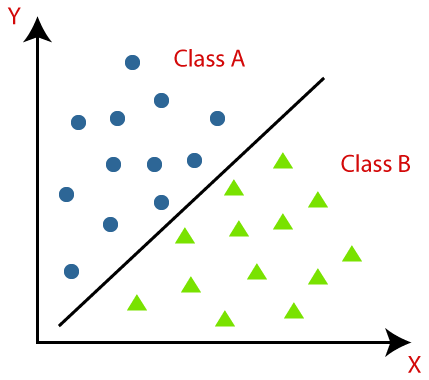

For our classification task, we have to correctly classify the samples into two classes. This is a binary classification problem.

One of the simplest binary classification models in machine learning is Logistic Regression. It uses the logistic (sigmoid) function to output a value between 0 and 1.

Here's how the function looks like.
Taken from [here](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc).

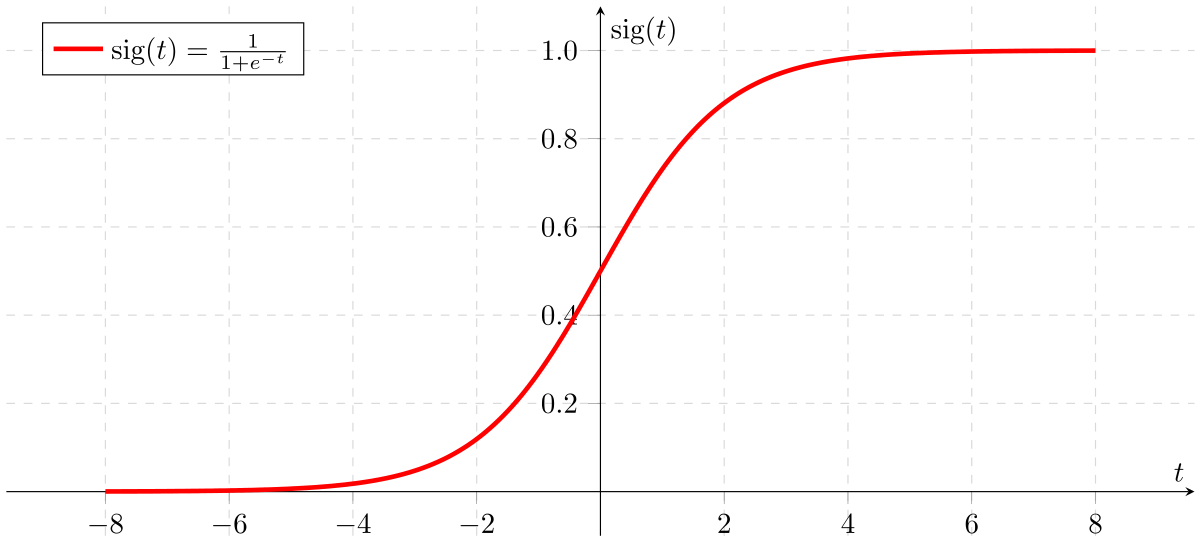

In essence, it's a regression model that learns the pattern between the input and output and passes the result through an activation function (sigmoid in this case).

We will use the scikit-learn package to implement the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model.


In [ ]:
# Import the Logistic Regression Class from sklearn.
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

## Load other processing modules.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LogisticRegression(solver='lbfgs'))

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

Spatio-temporal: 78.9%


# Dimensionality Reduction

It may be useful to reduce the dimensionality of data and not use all the features. One of the key benefits of reducing the number of features is that it takes less time for the model to train.

Another benefit is that it helps us to visualize data in 2-d or 3-d space.

## PCA


Here we will look at an important dimensionality reduction technique called PCA or Principal Component Analysis.

PCA is a technique which selects the features that contain highest information variance. In other words, it keeps the **first 'k'** 'components that contribute to the most information in the dataset.

PCA requires an understanding of eigenvalues and eigenvectors and [this](https://www.youtube.com/watch?v=PFDu9oVAE-g) video provides a intuitive understanding of it. 

Also, [this](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) article explains PCA in a simple way and [this](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) article provides various examples on other uses of PCA in general data science.

Let's implement [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and find out how many components contribute to most information in the dataset.

In [ ]:
#@title Run this cell to plot pca variance.
def plot_pca(pca_data):
  x_ticks = [i for i in range(len(pca_data))]
  cumsum = np.cumsum(pca_data)
  plt.xlabel('n_components')
  plt.ylabel('Explained variance')
  plt.title('Explained Variance of PCA components')
  plt.plot(x_ticks, cumsum)
  plt.show()

In [ ]:
# Import the PCA class from scikit-learn.
from sklearn.decomposition import PCA

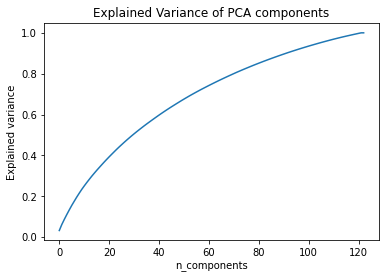

In [ ]:
scaler = StandardScaler()
mod_X_scaled = scaler.fit_transform(mod_X)  # Scaling data because PCA is susceptible to changes in feature ranges.
pca = PCA()  # Create PCA class.
pca.fit(mod_X_scaled)  # fit PCA to the 2-d data.
# Plot the variance explained by the components.
plot_pca(pca.explained_variance_ratio_)

# Exercise 1
Now that we have seen how varying the number of components explains the variance in the data, let's try to check the performance of our Logisitic Regression model.

Fill out the missing line below.

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))

scores = ...  # Complete this line. 
#Hint: Implement the cross_val_multiscore function and use different number of features.


# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score))

We see that a (almost) linear increase in explained variance as the number of components increase. Therefore, in this case it is reasonable to use all the features in the data and not apply any dimensionality reduction technique on the data. 

# Permutation Test

The permutation test is a way to test whether our accuracy is significantly above chance.

When we fit a machine learning model on our data, we assume that there is a relationship between the input data and the target variable. If there is a relationship that our model can decode, then we obtain good performance on the test data.

But how do we decide that our model's performance is better than just random 🤔?

The performance will be at chance if there is no relationship between the input data and target variable(s). In case of a binary classification problem, at random, the performance will be about 50% on an average.

The permutation test is one of the ways to determine significance but is usually combined with other techniques such as a t-test.
For your projects, it is recommended that statistical tests are carried out to provide strong support for results.

So in order to perform the permutation test, we need to shuffle the target labels.

[This](https://www.jmlr.org/papers/volume11/ojala10a/ojala10a.pdf) paper a comprehensive description of the test.

In [ ]:
# Shuffle the labels so that they are incorrectly assigned. We will use numpy's shuffle function and pass in the 'y' variable.
y_copy = np.copy(y)  # Make a copy of the original target value vector.
np.random.shuffle(y_copy)  # Shuffle the array in-place.

Now let's run the cross-validation framework again and look at the accuracy.

In [ ]:
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LogisticRegression(solver='lbfgs'))

scores = cross_val_multiscore(clf, X, y_copy, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

Spatio-temporal: 59.3%


NOTE: For each permutation (each shuffle) you will get different results. This is expected because the the order of the values are different in each case.

Generally, we want an expected (average) value, or an average over many runs.
Which will be our next exercise 💪.

# Exercise 2

In the second exercise, we want to know the average accuracy for the permutation test across many iterations.

Here's what needs to be done. Use the cross_val_multiscore function and run it multiple times. Then calculate the average accuracy across those runs.

Hint: You might want to use the [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) function, a [for](https://wiki.python.org/moin/ForLoop) loop, and a python [list](https://https://docs.python.org/2/tutorial/datastructures.html).

There are different ways to write the code so the exact implementation may differ.

In [ ]:
## Write your code here.

# Conclusion
In this notebook, we learned the following:


1.   Understood what a classfication problem is.
2.   Used scikit-learn to implement a Logistic Regression model.
3.   Applied PCA on the dataset and understood the effect of dimensionality reduction on the data.
4.   Understood permutation test as a way of evaluating model performance.


Now, you should be able equipped with the basic tools for your project.
Good Luck! 🎉